In [ ]:
# !pip install causalml
!pip install linearmodels

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data_url = "https://vincentarelbundock.github.io/Rdatasets/csv/AER/CollegeDistance.csv"
college_data = pd.read_csv(data_url)
college_data = college_data.drop(columns=['rownames'])
college_data.head()

,gender,ethnicity,score,fcollege,mcollege,home,urban,unemp,wage,distance,tuition,education,income,region
0,male,other,39.150002,yes,no,yes,yes,6.2,8.09,0.2,0.88915,12,high,other
1,female,other,48.869999,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
2,male,other,48.740002,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
3,male,afam,40.400002,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
4,female,other,40.480000,no,no,no,yes,5.6,8.09,0.4,0.88915,13,low,other


- education	최종 학력 (교육 연수)
- wage	임금 (시간당)
- distance	거주지에서 가장 가까운 4년제 대학까지의 거리 (10마일 단위)
- gender	성별 (예: female, male)
- ethnicity	인종 (예: afam, hisp, other)
- score	고등학교 재학 중 치른 종합 시험 점수
- fcollege	아버지가 대학 졸업자인지 여부 (factor)
- mcollege	어머니가 대학 졸업자인지 여부 (factor)
- home	자가 거주 여부 (factor)
- urban	학교가 도시에 위치하는지 여부 (factor)
- unemp	1980년 기준 거주 카운티의 실업률
- tuition	주(state)의 평균 4년제 대학 등록금 (1000달러 단위)
- income	가구 소득이 $25,000를 초과하는지 여부 (factor)
- region	거주 지역 (예: west, other)

# EDA

In [ ]:
# 교육을 해도..? 잘 모르겠는데?
college_data[['wage', 'education']].groupby('education').agg(['mean', 'min', 'max', 'count'])

wage                   
               mean   min    max count
education                             
12         9.472707  6.59  12.96  1832
13         9.448630  6.59  12.96   613
14         9.512799  6.59  12.96   518
15         9.532230  6.59  12.96   556
16         9.564829  6.59  12.96   907
17         9.492227  6.59  12.96   256
18         9.544386  7.04  12.96    57

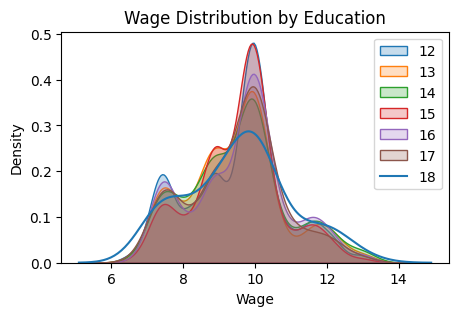

In [ ]:
edu12_wage = college_data.loc[college_data['education'] == 12, 'wage']
edu13_wage = college_data.loc[college_data['education'] == 13, 'wage']
edu14_wage = college_data.loc[college_data['education'] == 14, 'wage']
edu15_wage = college_data.loc[college_data['education'] == 15, 'wage']
edu16_wage = college_data.loc[college_data['education'] == 16, 'wage']
edu17_wage = college_data.loc[college_data['education'] == 17, 'wage']
edu18_wage = college_data.loc[college_data['education'] == 18, 'wage']

# 그림으로 확인
plt.figure(figsize=(5, 3))
sns.kdeplot(edu12_wage, label='12', fill=True)
sns.kdeplot(edu13_wage, label='13', fill=True)
sns.kdeplot(edu14_wage, label='14', fill=True)
sns.kdeplot(edu15_wage, label='15', fill=True)
sns.kdeplot(edu16_wage, label='16', fill=True)
sns.kdeplot(edu17_wage, label='17', fill=True)
sns.kdeplot(edu18_wage, label='18', fill=False)

plt.title('Wage Distribution by Education')
plt.xlabel('Wage')
plt.legend()
plt.show()

# 교육이... 소득에 영향을 미칠까?

In [ ]:
# income: 소득, 25,000 달러 이상인가?
college_data[['wage', 'income']].groupby('income').agg(['mean', 'min', 'max'])

wage             
            mean   min    max
income                       
high    9.652044  6.59  12.96
low     9.439200  6.59  12.96

소득이 높거나 낮아도 가구소득에는 큰 영향이 없는 것 같음.

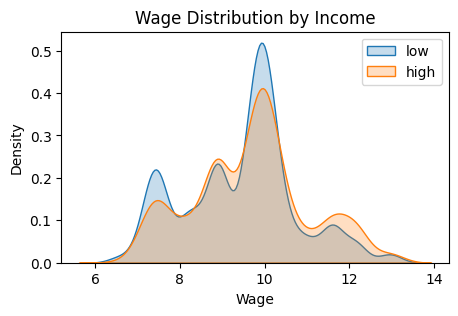

In [ ]:
income_low_wage = college_data.loc[college_data['income'] == 'low', 'wage']
income_high_wage = college_data.loc[college_data['income'] == 'high', 'wage']

# 그림으로 확인
plt.figure(figsize=(5, 3))
sns.kdeplot(income_low_wage, label='low', fill=True)
sns.kdeplot(income_high_wage, label='high', fill=True)

plt.title('Wage Distribution by Income')
plt.xlabel('Wage')
plt.legend()
plt.show()

# 내 소득이 높거나 낮아도 가구소득에는 큰 영향이 없는 것 같음.

# distance를 도구변수로 사용하기 적당한지 확인

## 문제:
교육 수준(education)이 임금(wage)에 미치는 영향 확인

## 선택편향:
사람들은 자신의 교육 수준을 무작위로 배정받는 것이 아니라, 스스로 선택합니다. 대학에 가기로 "선택"한 사람들은 그렇지 않은 사람들보다 원래부터 더 성실하거나, 재능이 뛰어나거나, 목표 의식이 높을 가능성이 있습니다.
(내생성은 회귀분석 모델에서 설명변수(X)가 오차항(ε)과 상관관계를 가질 때 발생하는 문제)

---
"성실함, 재능, 목표 의식"과 같은 관찰되지 않는 특성들이 바로 내생성 문제의 핵심입니다.

1. 이 특성들은 당연히 임금(wage)에 긍정적인 영향을 줄 것입니다. (이들은 회귀식의 오차항 ε에 포함됩니다.)

2. 동시에 이 특성들은 개인이 대학에 가기로 선택(education) 하는 데에도 영향을 미칩니다.

3. 결과적으로, 설명변수인 education이 오차항 ε에 포함된 "관찰되지 않는 특성"들과 상관관계를 갖게 됩니다. 즉, Cov(education, ε) ≠ 0 이 되어 내생성 문제가 발생하는 것입니다.


In [4]:
# 문제 단순화
df = college_data[['wage', 'education' , 'distance', 'score']]
df.head()

,wage,education,distance,score
0,8.09,12,0.2,39.150002
1,8.09,12,0.2,48.869999
2,8.09,12,0.2,48.740002
3,8.09,12,0.2,40.400002
4,8.09,13,0.4,40.480000


In [7]:
# Original Equation
Y = df['wage']
X = df[['education']]#, 'score', 'distance']] #

# OLS 모델 적합
model = sm.OLS(Y, sm.add_constant(X))
results = model.fit()

# 결과 확인
print(results.summary())
# 1. education이 높아질수록 임금은 낮아진다? education : -0.0288
# 2. distance를 제외해도 부호의 방향은 같으며 education : -0.0291
# 3. education만 있다면 회귀 계수는 양수 값이 나옴. education : 0.0179
## score(=고등학교 재학 중 치른 종합 시험 점수)에는 이미 개인의 재능이나 성실 이라는 측정 불가능한 항목이 있었기 때문이라 보임.

# 잔차와 상관관계 확인
residuals = results.resid
np.corrcoef(residuals, college_data['education']) # 3가지 케이스 전부 0..

# 이러면 내생성 문제가 없는 것 아닌가?, 그래도 내생성은 있다고 흐린눈으로 보고 가야할까?
# 아쉽게도, 검정할 수 있는 방법은 없으며 데이터에 대한 깊은 이해가 있어야 한다고 한다.
# 이거... 너무 별론데?

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.698
Date:                Sun, 31 Aug 2025   Prob (F-statistic):              0.101
Time:                        00:45:34   Log-Likelihood:                -8120.3
No. Observations:                4739   AIC:                         1.624e+04
Df Residuals:                    4737   BIC:                         1.626e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.2532      0.152     60.949      0.0

array([[ 1.00000000e+00, -9.08963113e-16],
       [-9.08963113e-16,  1.00000000e+00]])

## first stage
education ~ distance + ...

* 도구변수인 distance가 education을 잘 설명하는지 확인하기

In [9]:
Y = df['education']
X = df[['distance', 'score']]

# OLS 모델 적합
first_model = sm.OLS(Y, sm.add_constant(X))
results = first_model.fit()

# 결과 확인
print(results.summary())

residuals = results.resid

np.corrcoef(residuals, college_data['distance']) # 거의 0..

# distance t-value = -6.441
# 상관 관계는 거의 0
# 즉, distance는 education을 예측하는데 강력한 도구이고,
# 외생성 문제는.. 잘 넘어간다.? 이게 맘에 안드네

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     21.99
Date:                Sun, 31 Aug 2025   Prob (F-statistic):           2.81e-06
Time:                        00:47:42   Log-Likelihood:                -16966.
No. Observations:                4739   AIC:                         3.394e+04
Df Residuals:                    4737   BIC:                         3.395e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.3533      0.160    320.275      0.0

array([[1.00000000e+00, 8.37752332e-16],
       [8.37752332e-16, 1.00000000e+00]])

## second stage
wage ~ education_hat + distance + ...


In [ ]:
education_hat = first_model.fit().predict(sm.add_constant(X))
X = df[['score']].copy()
X.loc[:, 'education_hat'] = education_hat
X

,score,education_hat
0,39.150002,12.772374
1,48.869999,13.693614
2,48.740002,13.681293
3,40.400002,12.890846
4,40.480000,12.888795
...,...,...
4734,56.529999,14.390710
4735,59.770000,14.697791
4736,43.169998,13.124479
4737,49.970001,13.768968


In [ ]:
X_2nd = sm.add_constant(X)
model_2nd = sm.OLS(college_data['wage'], X_2nd)
results_2nd = model_2nd.fit()
print(results_2nd.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     32.79
Date:                Sat, 23 Aug 2025   Prob (F-statistic):           7.18e-15
Time:                        11:38:44   Log-Likelihood:                -8089.1
No. Observations:                4739   AIC:                         1.618e+04
Df Residuals:                    4736   BIC:                         1.620e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             9.4063      1.574      5.976

In [20]:
from linearmodels.iv import IV2SLS

dependent = df['wage']
exog = sm.add_constant(df['score'])

endog = df["education"]
instruments = df["distance"]
mod = IV2SLS(dependent, exog, endog, instruments).fit()
print(mod)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                   wage   R-squared:                      0.0093
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0089
No. Observations:                4739   F-statistic:                    66.753
Date:                Sun, Aug 31 2025   P-value (F-stat)                0.0000
Time:                        01:03:51   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          9.4063     1.4618     6.4345     0.0000      6.5411      12.271
score          0.0268     0.0156     1.7120     0.08

결론... 교육은 임금을 높히는데 도움이 되지 않는다.???

다른 조건이 동일할 때, '거리' 때문에 교육을 1단위 더 받게 된 사람들은 평균적으로 임금이 약 -0.092 단위 더 낮다.

--> 만약 사실이라면 교육에 대한 효과는 별 볼일 없다. (0에 가깝기 때문)

이후, R^2를 높히려 했지만 실패

# 한 번 더...

In [62]:
category_var = ['gender','ethnicity','fcollege','mcollege','home','urban','income','region']
df_dummies = pd.get_dummies(college_data, columns=category_var, drop_first=True)



dependent = df_dummies['wage']
instruments = df_dummies["distance"]

exog = sm.add_constant(df_dummies[['unemp']])
endog = df_dummies[["education"]]

mod = IV2SLS(dependent, exog, endog, instruments).fit()
print(mod)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                   wage   R-squared:                     -0.6612
Estimator:                    IV-2SLS   Adj. R-squared:                -0.6619
No. Observations:                4739   F-statistic:                    211.26
Date:                Sun, Aug 31 2025   P-value (F-stat)                0.0000
Time:                        01:27:34   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.6967     2.1237    -0.3281     0.7429     -4.8591      3.4656
unemp          0.1360     0.0096     14.163     0.00

In [31]:
df_dummies

,score,unemp,wage,distance,tuition,education,gender_male,ethnicity_hispanic,ethnicity_other,fcollege_yes,mcollege_yes,home_yes,urban_yes,income_low,region_west
0,39.150002,6.2,8.09,0.2,0.88915,12,True,False,True,True,False,True,True,False,False
1,48.869999,6.2,8.09,0.2,0.88915,12,False,False,True,False,False,True,True,True,False
2,48.740002,6.2,8.09,0.2,0.88915,12,True,False,True,False,False,True,True,True,False
3,40.400002,6.2,8.09,0.2,0.88915,12,True,False,False,False,False,True,True,True,False
4,40.480000,5.6,8.09,0.4,0.88915,13,False,False,True,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4734,56.529999,6.6,8.89,0.8,0.25751,13,True,False,False,False,False,True,False,False,True
4735,59.770000,6.6,8.89,0.8,0.25751,15,True,False,False,False,False,True,False,False,True
4736,43.169998,6.6,8.89,0.8,0.25751,12,True,False,True,False,False,True,False,False,True
4737,49.970001,6.6,8.89,0.8,0.25751,16,True,False,False,True,True,True,False,False,True


In [68]:
category_var = ['gender','ethnicity','fcollege','mcollege','home','urban','income','region']
df_dummies = pd.get_dummies(college_data, columns=category_var, drop_first=True)


dependent = df_dummies['wage']
instruments = df_dummies["distance"]

exog = sm.add_constant(df_dummies.drop(columns=['wage', 'distance', 'education'
,     'urban_yes', 'home_yes', 'income_low', 'mcollege_yes', 'fcollege_yes', 'fcollege_yes', 'score'
, 'ethnicity_hispanic', 'ethnicity_other', 'gender_male']))
endog = df_dummies[["education"]]

mod = IV2SLS(dependent, exog, endog, instruments).fit()
print(mod)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                   wage   R-squared:                      0.0002
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0006
No. Observations:                4739   F-statistic:                    941.35
Date:                Sun, Aug 31 2025   P-value (F-stat)                0.0000
Time:                        01:28:12   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
const           3.2376     1.7653     1.8340     0.0667     -0.2223      6.6975
unemp           0.1050     0.0073     14.302    